In [20]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [2]:
df_dev = load_dataset("csv", data_files="subtaskA_train.csv")
df_test = load_dataset("csv", data_files="subtaskA_test.csv")

Found cached dataset csv (C:/Users/irene/.cache/huggingface/datasets/csv/default-f6a552f9796a6277/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset csv (C:/Users/irene/.cache/huggingface/datasets/csv/default-a208f18522f18d4d/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

# Data partioning

In [3]:
train_val = df_dev['train'].train_test_split(test_size=0.3)
df_train = train_val["train"]
df_val = train_val["test"]

In [4]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val = df_val.rename_column("comment_text", "text")
df_val = df_val.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

# Model loading

In [5]:
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-uncased")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

# Data preprocessing

In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1289 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\irene\.cache\huggingface\datasets\csv\default-a208f18522f18d4d\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-fbae992f76d03b25.arrow


In [7]:
tokenized_train

Dataset({
    features: ['Id', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1289
})

In [8]:
small_train_dataset = tokenized_train.shuffle(seed=42).select(range(15))
small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(5))

# Training

In [14]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    logging_strategy="epoch",
    num_train_epochs=3
    )

In [15]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()

c:\Users\irene\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

{'loss': 0.6261, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6287623643875122, 'eval_f1': 0.8, 'eval_runtime': 8.7813, 'eval_samples_per_second': 0.569, 'eval_steps_per_second': 0.114, 'epoch': 1.0}
{'loss': 0.501, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5171900391578674, 'eval_f1': 0.8, 'eval_runtime': 8.3431, 'eval_samples_per_second': 0.599, 'eval_steps_per_second': 0.12, 'epoch': 2.0}
{'loss': 0.4281, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.4789329469203949, 'eval_f1': 0.8, 'eval_runtime': 8.3375, 'eval_samples_per_second': 0.6, 'eval_steps_per_second': 0.12, 'epoch': 3.0}
{'train_runtime': 150.7872, 'train_samples_per_second': 0.298, 'train_steps_per_second': 0.04, 'train_loss': 0.5184028744697571, 'epoch': 3.0}


TrainOutput(global_step=6, training_loss=0.5184028744697571, metrics={'train_runtime': 150.7872, 'train_samples_per_second': 0.298, 'train_steps_per_second': 0.04, 'train_loss': 0.5184028744697571, 'epoch': 3.0})

# Evaluation

In [26]:
log_history = trainer.state.log_history

7

In [29]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
df

C:\Users\irene\AppData\Local\Temp\ipykernel_4520\2467079435.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
C:\Users\irene\AppData\Local\Temp\ipykernel_4520\2467079435.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
C:\Users\irene\AppData\Local\Temp\ipykernel_4520\2467079435.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
C:\Users\irene\AppData\Local\Temp\ipykernel_4520\2467079435.py:10: FutureWarning: The frame.append method is deprecated and wil

,Epoch,Loss,Dataset
0,1,0.626100,Training
1,1,0.628762,Validation
2,2,0.501000,Training
3,2,0.517190,Validation
4,3,0.428100,Training
5,3,0.478933,Validation


Text(0.5, 0, 'Epoca')

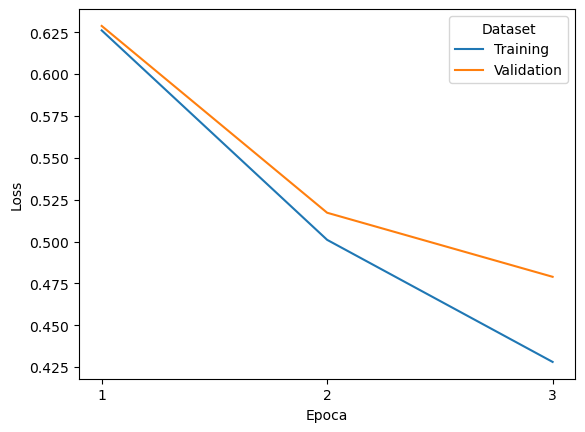

In [30]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 4))
plt.xlabel('Epoca')